# MuSCAT 2 mock light curve generation

The `MockLC` class aims to generate realistic MuSCAT2 transit light curves for a given planet, white noise levels, and red noise hyperparameters. The red noise is modelled as a Gaussian process (GP) with an Exponential kernel, and uses `George` for the GP computation.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import exodata
from exodata import astroquantities as qn
from exodata.astroquantities import Quantity as Qty

from george import GP
from george.kernels import ExpKernel

from pytransit import MandelAgol as MA
from pytransit.orbits_f import orbits as of

warnings.filterwarnings("ignore", category=UserWarning)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    exocat = exodata.OECDatabase('../ext/oec/systems/')

In [3]:
try:
    from george import GP
    from george.kernels import ExpKernel, Matern32Kernel
    with_george = True
except ImportError:
    with_george = False

class MockLC:    
    def __init__(self, planet_name='wasp-80b', **kwargs):
        self.t_exposure_d = Qty(kwargs.get('exptime', 60), 's').rescale('d')
        self.t_baseline_d = Qty(kwargs.get('bltime', 0.5), 'h').rescale('d')
        
        self.ldcs = array([[0.80,0.02],[0.61,0.16],[0.45,0.20],[0.36,0.20]])
        self.filters = 'g r i z'.split()
        self.npb = len(self.filters)
        
        self.planet = planet = exocat.searchPlanet(planet_name)
        self.star = star = planet.star
    
        self.p = float(planet.P)
        self.k = float(planet.R.rescale('R_s') / star.R)
        self.a = float(planet.getParam('semimajoraxis').rescale('R_s') / star.R)
        self.i = float(planet.getParam('inclination').rescale('rad'))
        self.b = float(self.a * cos(planet.getParam('inclination').rescale('rad')))
        self.duration_d = Qty(of.duration_eccentric_f(self.p, self.k, self.a, self.i, 0, 0, 1), 'd')


    @property
    def t_total_d(self):
        return self.duration_d + 2*self.t_baseline_d
        
    @property
    def duration_h(self):
        return self.duration_d.rescale('h')

    @property
    def n_exp(self):
        return int(self.t_total_d // self.t_exposure_d)
    
    def __call__(self, rseed=0, ldcs=None, wnsigma=None, rnsigma=None, rntscale=0.5):
        return self.create(rseed, ldcs, wnsigma, rnsigma, rntscale)
    
    def create(self, rseed=0, ldcs=None, wnsigma=None, rnsigma=None, rntscale=0.5):
        ldcs = ldcs if ldcs is not None else self.ldcs
        seed(rseed)
        
        self.time = linspace(-0.5*float(self.t_total_d), 0.5*float(self.t_total_d), self.n_exp)
        self.transit = MA().evaluate(self.time, self.k, ldcs, 0, self.p, self.a, self.i)
        self.npt = self.time.size
        
        # White noise
        # -----------
        if wnsigma is not None:
            self.wnoise = multivariate_normal(zeros(atleast_2d(self.transit).shape[1]), diag(wnsigma)**2, self.npt)
        else:
            self.wnoise = zeros_like(self.transit)

        # Red noise
        # ---------
        if rnsigma and with_george:
            self.gp = GP(rnsigma**2 * ExpKernel(rntscale))
            self.gp.compute(self.time)
            self.rnoise = self.gp.sample(self.time, self.npb).T
            self.rnoise -= self.rnoise.mean(0)
        else:
            self.rnoise = zeros_like(self.transit)
            
        # Final light curve
        # -----------------
        self.time_h = Qty(self.time, 'd').rescale('h')
        self.flux = self.transit + self.wnoise + self.rnoise
        return self.time_h, self.flux
    
    
    def plot(self, figsize=(13,4)):
        fig,axs = subplots(1,3, figsize=figsize, sharex=True, sharey=True)
        yshift = 0.01*arange(4)
        axs[0].plot(self.time_h, self.flux + yshift)
        axs[1].plot(self.time_h, self.transit + yshift)
        axs[2].plot(self.time_h, 1 + self.rnoise + yshift)
        setp(axs, xlabel='Time [h]', xlim=self.time_h[[0,-1]])
        setp(axs[0], ylabel='Normalised flux')
        [setp(ax, title=title) for ax,title in 
           zip(axs, 'Transit model + noise, Transit model, Red noise'.split(', '))]
        fig.tight_layout()

In [4]:
lc = MockLC('CoRoT-1b', bltime=1.5)

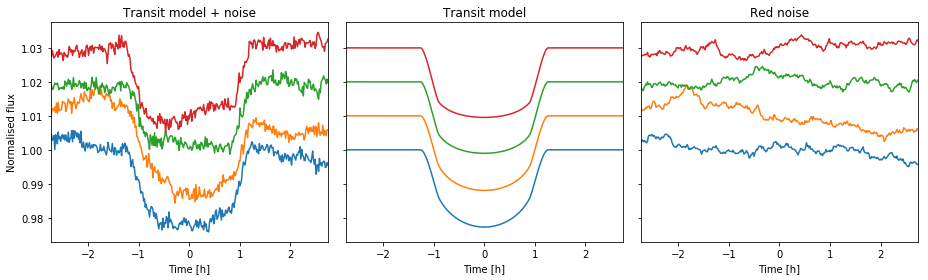

In [5]:
lc.create(wnsigma=[0.001, 0.001, 0.001, 0.001], rnsigma=0.01, rntscale=0.5);
lc.plot()

---
<center>&copy; 2017 Hannu Parviainen</center>